## Log2fold-change scatterplot

* Only plot genes with OMA pairwise ortholog
* Slight difference between negative control of Mir-197 and Mir-769 due to normalization of DESeq2

In [102]:
from pathlib import Path
import pandas as pd
# from rodent_loss_src.rnaseq import read_oma, parse_rnaseq
from rodent_loss_src.rnaseq import read_oma, parse_rnaseq, find_significant
import numpy as np

In [89]:
from collections import defaultdict

ORGANISMS = ["human", "mouse"]
MIRNAS = ["mir197", "mir769"]
PROJECTDIR = Path('.').resolve().parents[2]
oma_path = '../data/human_mouse_omapairwise.txt'
in_path = '../data/{}_results_Neg_vs_{}.tsv'
# figure_path = f'{PROJECTDIR}/publication/revision/NegCTRL_baseMean_correlation_normOn_{mirna}.png'

pairwise = read_oma(oma_path)

def prepare_scatterplot(in_path, pairwise, value='baseMean'):
    col = []
    for organism in ORGANISMS:
        for mirna in MIRNAS:
            rnadf = parse_rnaseq(in_path.format(organism, mirna), pairwise, organism, mirna)
            # display(rnadf)
            for i, row in rnadf.iterrows():
                gene = row.iloc[3]
                logchange = row.iloc[4]
                basemean = row.iloc[6]
                orthomap = row.iloc[0]
                if value == 'log2FoldChange':
                    col.append([orthomap, organism, mirna, gene, logchange])
                elif value == 'baseMean':
                    col.append([orthomap, organism, mirna, gene, basemean])
    
    df = pd.DataFrame(col, columns=['orthomap', 'organism', 'mirna', 'gene', value])
    df = df.dropna(subset=['orthomap'])
    return df
    
rnadf = prepare_scatterplot(in_path, pairwise)
display(rnadf)

,orthomap,organism,mirna,gene,baseMean
0,ENSG00000157933|ENSMUSG00000029050,human,mir197,SKI,847.105189
1,ENSG00000151012|ENSMUSG00000027737,human,mir197,SLC7A11,684.048915
2,ENSG00000086758|ENSMUSG00000025261,human,mir197,HUWE1,3933.364672
3,ENSG00000180694|ENSMUSG00000043252,human,mir197,TMEM64,399.292229
4,ENSG00000168615|ENSMUSG00000031555,human,mir197,ADAM9,691.420705
...,...,...,...,...,...
61392,ENSG00000286224|ENSMUSG00000117965,mouse,mir769,AC141477.1,3.511343
61393,ENSG00000203737|ENSMUSG00000118401,mouse,mir769,Gpr52,2.730489
61394,ENSG00000166359|ENSMUSG00000118454,mouse,mir769,Wdr88,4.705432
61395,ENSG00000268655|ENSMUSG00000118462,mouse,mir769,AC151602.1,1.191141


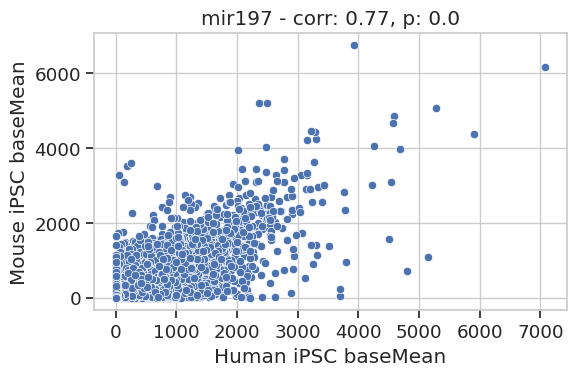

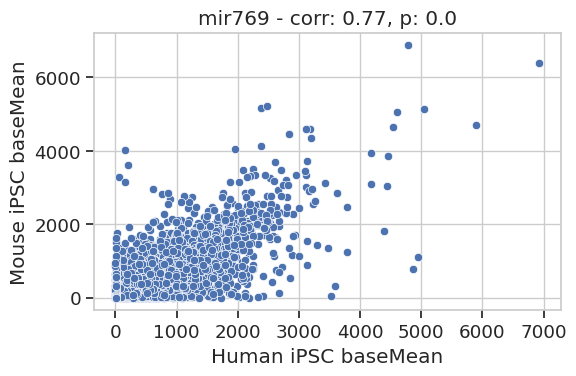

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt


def do_scatterplot(value='baseMean'):


    
    for i, mirna in enumerate(MIRNAS):
        mirdf = rnadf[rnadf.mirna == mirna]
        
        human_df = mirdf[mirdf.organism == 'human'].filter(['orthomap', value]).set_index('orthomap')
        mouse_df = mirdf[mirdf.organism == 'mouse'].filter(['orthomap', value]).set_index('orthomap')
    
        scatterdf = human_df.join(mouse_df, lsuffix='_human', rsuffix='_mouse', how='inner')
        corr, p = pearsonr(scatterdf[f'{value}_human'], scatterdf[f'{value}_mouse'])
    
        sns.set(rc={'figure.figsize':(6,4), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='whitegrid')
        sns.scatterplot(data=scatterdf, x=f'{value}_human', y=f'{value}_mouse')
        plt.title(f'{mirna} - corr: {round(corr, 2)}, p: {p}')
        plt.xlabel('Human iPSC baseMean')
        plt.ylabel('Mouse iPSC baseMean')
        plt.tight_layout()
        plt.savefig(f'{PROJECTDIR}/publication/revision/NegCTRL_baseMean_correlation_normOn_{mirna}.png', dpi=330)
        plt.show()
        # display(scatterdf)
    
        
        # break


do_scatterplot()

## Pearson correlation per gene

In [101]:
from pathlib import Path
import pandas as pd
# from rodent_loss_src.rnaseq import read_oma, parse_rnaseq
from rodent_loss_src.rnaseq import reads_per_gene_in_condition
import numpy as np

ORGANISMS = ["human", "mouse"]
MIRNAS = ["mir197", "mir769"]
PROJECTDIR = Path('.').resolve().parents[2]
oma_path = '../data/human_mouse_omapairwise.txt'
# in_path = '../data/{}_results_Neg_vs_{}.tsv'
countpath = '/home/felixl/PycharmProjects/rodent_loss/external_data/counts_matrix/{}_counts.matrix'


def find_orthostring(ensidseries, orthodict):
    outcol = []
    for entry in ensidseries.values:
        
        if entry.startswith('ENSG'):
            try:
                mapper = orthodict[entry]
            except KeyError:
                mapper = entry.upper()
        else:
            mapper = entry.upper()
        outcol.append(mapper)
    return outcol


col = []
pairwise = read_oma(oma_path)
for organism in ORGANISMS:
    reads_df = reads_per_gene_in_condition(countpath.format(organism))
    reads_df = reads_df.rename(columns=lambda col: f'{organism}_{col}')
    mapcol = find_orthostring(reads_df.index, pairwise)
    reads_df.index = mapcol
    reads_df = reads_df.rename(columns=lambda col: col.replace('Neg-Ctl', 'CTRL'))
    display(reads_df)
    
    col.append(reads_df)


df = col[0].join(col[1], how='inner')
display(df)


,human_CTRL_1,human_CTRL_2,human_CTRL_3,human_miR-197_1,human_miR-197_2,human_miR-197_3,human_miR-769_1,human_miR-769_2,human_miR-769_3
PHF3,2487,2459,2625,2460,2770,2514,2455,2574,2482
ENSG00000262766,5,5,0,6,0,2,2,2,2
CACYBPP2,13,15,12,14,13,9,13,12,12
CDYL,715,706,718,647,770,653,694,693,682
UTP6,559,599,604,560,766,578,569,600,716
...,...,...,...,...,...,...,...,...,...
PSEN1,647,652,688,658,620,607,652,658,665
ENSG00000265750,3,1,8,4,3,1,3,1,2
CYB561,211,193,222,187,168,192,231,235,260
MECOM,518,524,528,624,594,666,497,566,527


,mouse_CTRL_1,mouse_CTRL_2,mouse_CTRL_3,mouse_CTRL_4,mouse_miR-197_1,mouse_miR-197_2,mouse_miR-197_3,mouse_miR-197_4,mouse_miR-769_1,mouse_miR-769_2,mouse_miR-769_3
RPL29,228,248,215,239,238,282,236,260,279,250,253
TIMMDC1,154,146,173,166,154,181,180,150,147,146,176
IZUMO4,16,8,12,9,12,10,15,13,13,6,17
PDXK,194,196,168,181,194,176,162,185,127,128,94
FBXO9,202,194,194,206,179,210,218,186,213,186,190
...,...,...,...,...,...,...,...,...,...,...,...
9830004L10RIK,3,2,2,1,4,0,1,1,3,2,0
ZFP52,52,44,57,57,55,66,59,63,37,48,45
SUOX,53,48,41,47,33,32,30,28,32,46,31
GM37423,59,37,66,49,32,49,54,41,36,41,45


,human_CTRL_1,human_CTRL_2,human_CTRL_3,human_miR-197_1,human_miR-197_2,human_miR-197_3,human_miR-769_1,human_miR-769_2,human_miR-769_3,mouse_CTRL_1,mouse_CTRL_2,mouse_CTRL_3,mouse_CTRL_4,mouse_miR-197_1,mouse_miR-197_2,mouse_miR-197_3,mouse_miR-197_4,mouse_miR-769_1,mouse_miR-769_2,mouse_miR-769_3
PHF3,2487,2459,2625,2460,2770,2514,2455,2574,2482,2185,2228,2305,2235,2246,2428,2310,2360,2557,2437,2435
CDYL,715,706,718,647,770,653,694,693,682,599,554,544,590,597,634,624,656,665,649,626
UTP6,559,599,604,560,766,578,569,600,716,1049,1091,1102,1145,1061,1088,1073,1105,1071,1039,1030
MTRR,312,284,336,387,333,381,315,367,326,446,434,442,432,345,334,369,360,419,459,431
MARK4,407,414,352,438,424,396,403,350,382,168,199,194,183,221,234,251,207,165,184,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDHA,732,714,771,813,830,811,774,818,736,629,661,613,681,574,626,533,623,674,625,616
WDR3,1048,1030,1034,1041,1142,1041,1060,1045,1062,897,934,924,978,853,916,829,888,913,919,889
PSEN1,647,652,688,658,620,607,652,658,665,453,455,469,449,464,467,413,443,424,432,418
CYB561,211,193,222,187,168,192,231,235,260,163,163,146,160,150,142,117,175,114,110,84


## Filter for negative control and calculate Pearson correlation

In [100]:
from scipy.stats import pearsonr

def pearson_correlation(df):
    pearson_correlations = []
    for gene in df.index:
        human_expr = df.loc[gene, ['human_CTRL_1', 'human_CTRL_2', 'human_CTRL_3']].values
        mouse_expr = df.loc[gene, ['mouse_CTRL_1', 'mouse_CTRL_2', 'mouse_CTRL_3']].values

    
        # Calculate Pearson correlation for this gene
        corr, _ = pearsonr(human_expr, mouse_expr)
        pearson_correlations.append(corr)
    df['pearson_correlation'] = pearson_correlations
    return df


neg_columns = [col for col in df.columns.values if 'CTRL' in col]
neg_df = df.filter(neg_columns)
display(neg_df)
# corr_df = pearson_correlation(neg_df)


display(corr_df)

,human_CTRL_1,human_CTRL_2,human_CTRL_3,mouse_CTRL_1,mouse_CTRL_2,mouse_CTRL_3,mouse_CTRL_4
PHF3,2487,2459,2625,2185,2228,2305,2235
CDYL,715,706,718,599,554,544,590
UTP6,559,599,604,1049,1091,1102,1145
MTRR,312,284,336,446,434,442,432
MARK4,407,414,352,168,199,194,183
...,...,...,...,...,...,...,...
LDHA,732,714,771,629,661,613,681
WDR3,1048,1030,1034,897,934,924,978
PSEN1,647,652,688,453,455,469,449
CYB561,211,193,222,163,163,146,160


,human_CTRL_1,human_CTRL_2,human_CTRL_3,mouse_CTRL_1,mouse_CTRL_2,mouse_CTRL_3,mouse_CTRL_4,pearson_correlation
PHF3,2487,2459,2625,2185,2228,2305,2235,0.867993
CDYL,715,706,718,599,554,544,590,0.109312
UTP6,559,599,604,1049,1091,1102,1145,0.995358
MTRR,312,284,336,446,434,442,432,0.687548
MARK4,407,414,352,168,199,194,183,-0.266307
...,...,...,...,...,...,...,...,...
LDHA,732,714,771,629,661,613,681,-0.921174
WDR3,1048,1030,1034,897,934,924,978,-0.998695
PSEN1,647,652,688,453,455,469,449,0.999996
CYB561,211,193,222,163,163,146,160,-0.788723
